## 4. Further Hero-wise Skill Analysis Based On Random Forest

It is evident that linear regression cannot help us to yield a convincing conclusion based on the Overwatch League Match data. You may wonder if we could use the Multiple Linear Regression instead? Well, there are drawbacks/disadvantages for our cases. And it really comes down to the datasets we are using for the matter.

In order to fully utilize the power of Multiple Linear Regression, many of the assumptions must be made in order to ensure that the raw data matches with the expectation of the data modeling process. In addition, almost no indicators in our datasets has displayed a strong and simple causal relationship between the predictor and response. And in our case, we only removed noise/outliers in a rather direct manner by hard filtering the data.

However, when it comes to Random Forest as mentioned in the class previously, it can resolve issues associated with regression and classification. And as the decision trees were trained by bootstrap aggregating, the bagging process helps to reduce the yield of poor model with low accuracy. Also, it reduces the happening of overfitting of the data.

Therefore, let's dive in and see how well we can tackle with the stats and winning rate from another perspective.

### 4.1 Data Cleaning

In this section, we will prepare the data for each match of 2019 and 2020 similarly to what we did in the previous section.

In [1]:
import pandas as pd
import sklearn
import numpy as np
#import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns

`Function name`: pre_cleansing

`Description`:

The function cleans the match statistics data and removes the ones that have low to no information for a given match.

`Input`:

1. Match_stats [DataFrame]: It includes all the players' information for all matches of a given year.

`Output`:

1. Match_stats_sanitized [DataFrame]: It includes the cleaned data.

In [2]:
def data_pre_cleansing(Match_stats):    
    drop_list =[]
    hero = Match_stats.loc[0,'hero']
    flag = False

    # Delete range
    range_begin = 0
    range_end = 0

    for index, row in Match_stats.iterrows():
        # If Alive Time < 30 sec
        if(row.stat_name == 'Time Alive'):
            if(row.stat_amount < 30):
                flag = True
        if(row.stat_name == 'Time Played'):
            if(row.stat_amount < 30):
                flag = True        

        if(row.hero!= hero):
            hero = row.hero
            range_end = index-1

        # If stat less than 6
            if((range_end-range_begin+1)< 6): 
                flag = True

            if(flag):
                # print(range_begin,'-',range_end)
                drop_list.append((range_begin,range_end))
            range_begin = index
            flag = False
        if index == Match_stats.index[-1]:
            if(flag):
#                 print(range_begin,'-',index)
                drop_list.append((range_begin,index))
    return drop_list

def drop_data(list,data):
    full_drop_list = []
    for pair in list:
        for x in range(pair[0],pair[1]): 
            full_drop_list.append(x)
    return data.drop(full_drop_list,axis=0)

def pre_cleansing(Match_stats):
    drop_list = data_pre_cleansing(Match_stats)
    return drop_data(drop_list,Match_stats) 

Read in datasets in one go.

In [3]:
phs_2019 = pd.read_csv('Data/phs_2019_playoffs.csv')
phs_2020_1 = pd.read_csv('Data/phs_2020_1.csv')
phs_2020_2 = pd.read_csv('Data/phs_2020_2.csv')

`Function name`: cleaning_aft

`Description`: 

This function aims at removing outliers and noise in the datasets. It is possible that some of the players switched heros temporarily. As a result, due to the short play time, it is possible that many stats of the gameplay have yet to become available. Therefore, to reduce the influence on the overall modeling, gameplay less than 30 seconds, or stats less than 6 variables will be removed.

`Input`:

1. csv_before [DataFrame]: It includes the data from gameplays collected from 2019 and 2020.

`Output`:

1. csv_before [DataFrame]: The sanitized data based on filtering rules.


In [4]:
def cleaning_aft(csv_before):
    csv_before = pre_cleansing(csv_before) 
    csv_before.drop(columns=['start_time','stage','map_type'],inplace=True)
    csv_before.drop(csv_before[(csv_before.hero == "All Heroes")].index, inplace=True) 
    return csv_before

In [5]:
clean_df_2019 = cleaning_aft(phs_2019)
clean_df_2020_1 = cleaning_aft(phs_2020_1)
clean_df_2020_2 = cleaning_aft(phs_2020_2)

Merge those datasets together as we put all the dragon balls together.

In [6]:
frames = [clean_df_2019, clean_df_2020_1,clean_df_2020_2]
total_data = pd.concat(frames)
total_data

,match_id,map_name,player,team,stat_name,hero,stat_amount
28,30172,Ilios,Elsa,Chengdu Hunters,All Damage Done,D.Va,13934.906430
29,30172,Ilios,Elsa,Chengdu Hunters,Assists,D.Va,15.000000
30,30172,Ilios,Elsa,Chengdu Hunters,Average Time Alive,D.Va,569.509017
31,30172,Ilios,Elsa,Chengdu Hunters,Barrier Damage Done,D.Va,6703.071256
32,30172,Ilios,Elsa,Chengdu Hunters,Critical Hit Accuracy,D.Va,0.092603
...,...,...,...,...,...,...,...
473159,35552,Hollywood,tobi,Seoul Dynasty,Time Played,Mercy,919.875289
473160,35552,Hollywood,tobi,Seoul Dynasty,Ultimates Earned - Fractional,Mercy,4.811592
473161,35552,Hollywood,tobi,Seoul Dynasty,Ultimates Used,Mercy,4.000000
473162,35552,Hollywood,tobi,Seoul Dynasty,Valkyrie Healing Efficiency,Mercy,301.680441


Now, let's do a quick inspection on how many heros are available for the matches.

In [7]:
total_data.hero.unique()

array(['D.Va', 'Sigma', 'Doomfist', 'Junkrat', 'Pharah', 'Lúcio', 'Moira',
       'Sombra', 'Symmetra', 'Baptiste', 'Mercy', 'Orisa',
       'Wrecking Ball', 'Zarya', 'Reaper', 'Tracer', 'Ana', 'Winston',
       'McCree', 'Widowmaker', 'Ashe', 'Mei', 'Hanzo', 'Bastion',
       'Brigitte', 'Reinhardt', 'Zenyatta', 'Roadhog', 'Genji',
       'Soldier: 76', 'Torbjörn', 'Echo'], dtype=object)

In [8]:
# number of different match_id
print('Number of different match_id:', total_data.match_id.nunique())

Number of different match_id: 336


In [9]:
# number of records in each match_id
total_data.match_id.value_counts()

30175    6709
34516    5979
34515    5331
34620    5102
34502    4924
         ... 
36205      54
36201      54
36202      39
36197      38
36221      37
Name: match_id, Length: 336, dtype: int64

We have to backport the winning rate information calculated based on Section 2.

`annual_match_result_table.csv` contains the sanitized overall match information generated from Section 2.

In [10]:
match_result = pd.read_csv('Data/annual_match_result_table.csv')
match_result

,match_year,match_id,map_name,map_winner,winning_team_final_map_score,winning_team_win_rate,map_loser,losing_team_final_map_score,losing_team_win_rate
0,2018,10223,Dorado,Los Angeles Valiant,3,0.600000,San Francisco Shock,2,0.400000
1,2018,10223,Temple of Anubis,Los Angeles Valiant,4,0.571429,San Francisco Shock,3,0.428571
2,2018,10223,Ilios,Los Angeles Valiant,2,0.666667,San Francisco Shock,1,0.333333
3,2018,10223,Numbani,Los Angeles Valiant,2,0.666667,San Francisco Shock,1,0.333333
4,2018,10224,Dorado,Los Angeles Gladiators,1,1.000000,Shanghai Dragons,0,0.000000
...,...,...,...,...,...,...,...,...,...
4511,2021,37442,Dorado,Atlanta Reign,3,0.600000,Dallas Fuel,2,0.400000
4512,2021,37441,Ilios,Shanghai Dragons,2,1.000000,Atlanta Reign,0,0.000000
4513,2021,37441,Hanamura,Shanghai Dragons,3,0.600000,Atlanta Reign,2,0.400000
4514,2021,37441,King's Row,Shanghai Dragons,6,0.545455,Atlanta Reign,5,0.454545


`Function name`: clean_match

`Description`: 

This function aims at doing an inner join based on two DataFrames. We have to do so since we did not use any database tools in this project. We take out the data for the winning teams in each match so that we can perform analysis on how to win when you play a hero.

`Input`:

1. hero_name [String]: The name of the hero in String format.

2. match_info [DataFrame]: The overall records for the Overwatch League games.

`Output`:

1. hero_info [DataFrame]: The collection of the hero stats being played by the winning teams in the matches.


In [11]:
def clean_match(hero_name, match_info):
    clean_match_df = match_info.merge(match_result.iloc[:, :6], how = 'inner', left_on =['match_id', 'map_name', 'team'], right_on =['match_id', 'map_name', 'map_winner'])
    hero_info = clean_match_df[clean_match_df['hero'] == hero_name]
    if len(hero_info) == 0:
        return 'No record about the hero name: ' + hero_name
    else:
        return hero_info

### 4.2 Feature Extraction

In this part, we are going to extract the features we are going to analyze for the model.

In [12]:
Top_11_stat_name = list(clean_df_2019.stat_name.value_counts()[:11].index)
Top_11_stat_name

['Ultimates Earned - Fractional',
 'Time Played',
 'Time Building Ultimate',
 'Time Elapsed per Ultimate Earned',
 'Time Alive',
 'Damage Taken',
 'Healing Received',
 'All Damage Done',
 'Hero Damage Done',
 'Average Time Alive',
 'Barrier Damage Done']

In [13]:
# Top 11 stat_name in year 2019 
clean_df_2019.stat_name.value_counts()[:11]

Ultimates Earned - Fractional       2078
Time Played                         1789
Time Building Ultimate              1787
Time Elapsed per Ultimate Earned    1781
Time Alive                          1781
Damage Taken                        1779
Healing Received                    1775
All Damage Done                     1758
Hero Damage Done                    1755
Average Time Alive                  1715
Barrier Damage Done                 1702
Name: stat_name, dtype: int64

`Function Name`: prepare_data

`Description`:

Sometimes, some of the stats were not populated for various reasons during the gameplays. Therefore, we are going to replace `NaN` with the mean value of the given variable.

`Input`:

1. data_set [DataFrame]: The collection of the hero stats being played by the winning teams in the matches.

`Output`:

1. data_set [DataFrame]: The dataset which has `NaN` removed/replaced.

In [14]:
def prepare_data(data_set):
   data_set = data_set[data_set.stat_name.isin(Top_11_stat_name)].iloc[:, [0,1, 4, 6, 10]]
   data_set = pd.pivot_table(data_set, values = ['stat_amount'], index = ['match_id', 'map_name','winning_team_win_rate'], columns = ['stat_name'])
   data_set = data_set.apply(lambda x: x.fillna(x.mean())) 
   return data_set

### 4.3 Feature Analysis

There are 11 common stat_name with the highly appearance frequency. we will use these 11 stat_names to do analysis to see the relationhsip between each of them and the winning rate

In [15]:
def regression(hero,stat_name):
    data = clean_match(hero,total_data)
    data_set = prepare_data(data)
    winning_rate = data_set.index.get_level_values(2).to_numpy().reshape(-1, 1)
    play_time = data_set.iloc[:, data_set.columns.get_level_values(1)=='Time Played'].values
    stat = data_set.iloc[:, data_set.columns.get_level_values(1)== stat_name].values.reshape(-1, 1)/play_time
    stat[stat == stat.max()] = stat.mean()
    stat[stat == stat.max()] = stat.mean()
    stat[stat == stat.min()] = stat.mean()
    return stat,winning_rate


It is important to notice that the Regression Trees are nonlinear and nonparametric, so any type of the relationships between predictors (stat_names) and the outcome variable(winning_team_win_rate) will be catched. Since building one regression tree will tend to have an inaccurate result, we will apply one multitree approach: Random Forests on the data. After we fit Random Forests to the data, we will get the importance scores for all the predictors. The higher imporatnce score is, the more useful corresponding predictor is. We can use the importance scores to do feature selection to pick the most useful preditors to avoid the curse of dimensionality. 

In the following section, we will apply Random Forests to data that related to three heros: D.Va, Ana, Solider: 76. Then we will pick the top 3 important features for each of the hero. Later, we will find the common important features. 

### 4.3.1 Hero D.Va Feature Analysis

In [16]:
# Create dataframe DVa_stat_unit_df of stat_name per unit for hero D.Va
stat_list = ['All Damage Done','Average Time Alive','Barrier Damage Done','Damage Taken','Healing Received','Hero Damage Done','Time Building Ultimate','Time Elapsed per Ultimate Earned','Ultimates Earned - Fractional']
DVa_stat_unit_df = pd.DataFrame()

for stat in stat_list:
    result_DVa = regression('D.Va',stat)
    stat_numeric_DVa = []
    for i in range(len(result_DVa[0])):
        stat_numeric_DVa.append(result_DVa[0][i][0])
    DVa_stat_unit_df[stat] = stat_numeric_DVa

# Add winning_rate column    
result_DVa = regression('D.Va','All Damage Done')
# convert array to float
win_rate_DVa = []
for i in range(len(result_DVa[1])):
    win_rate_DVa.append(result_DVa[1][i][0])
DVa_stat_unit_df['winning_team_win_rate'] = win_rate_DVa
# The complete dataframe
DVa_stat_unit_df

,All Damage Done,Average Time Alive,Barrier Damage Done,Damage Taken,Healing Received,Hero Damage Done,Time Building Ultimate,Time Elapsed per Ultimate Earned,Ultimates Earned - Fractional,winning_team_win_rate
0,25.436291,0.431799,13.512219,21.875276,11.863239,11.143322,0.965425,0.553851,0.011938,0.666667
1,16.680100,0.477583,7.941431,13.860362,5.921841,6.861956,0.899126,0.369970,0.010952,0.750000
2,11.258264,2.314794,1.634289,18.474740,18.241178,9.623975,1.007408,1.884288,0.009470,0.666667
3,23.150197,0.989472,5.170840,12.056977,12.056976,17.979357,0.989472,1.756253,0.014839,0.571429
4,16.786413,0.235195,6.660125,17.100303,10.773053,10.065393,0.790172,0.195033,0.000023,0.600000
...,...,...,...,...,...,...,...,...,...,...
548,16.786413,0.235195,6.660125,17.100303,10.773053,10.065393,0.790172,0.195033,0.000088,0.600000
549,22.777140,3.534514,100.088294,8.729276,8.437431,22.777140,1.015546,1.980977,0.013865,1.000000
550,16.786413,0.235195,6.660125,17.100303,10.773053,10.065393,0.790172,0.195033,0.000023,0.600000
551,13.701960,0.130614,2.429469,14.843716,7.618145,10.195635,0.792003,0.107001,0.012263,1.000000


In [17]:
# check the range of the each stat_name 
DVa_stat_unit_df.iloc[:, :-1].describe().round(2)

,All Damage Done,Average Time Alive,Barrier Damage Done,Damage Taken,Healing Received,Hero Damage Done,Time Building Ultimate,Time Elapsed per Ultimate Earned,Ultimates Earned - Fractional
count,553.00,553.00,553.00,553.00,553.00,553.00,553.00,553.00,553.00
mean,16.52,0.35,7.24,16.94,10.66,10.04,0.81,0.36,0.01
std,4.53,0.38,7.80,4.06,3.00,3.00,0.14,0.86,0.00
min,5.01,0.07,0.04,6.30,1.13,3.61,0.43,0.04,0.00
25%,13.62,0.16,4.41,14.78,8.99,8.26,0.73,0.11,0.01
50%,16.77,0.24,6.27,16.82,10.57,9.95,0.81,0.17,0.01
75%,19.27,0.33,8.18,18.78,12.15,11.58,0.89,0.28,0.01
max,51.02,3.53,100.09,52.09,32.80,32.04,2.43,13.62,0.03


We can see that all the stat_names are in different range. In order to make sure that every stat_name gets equal importance, we will normalize the value.

In [18]:
from sklearn.preprocessing import StandardScaler
# standardize the stat_name data
scaler_df = StandardScaler()

scaler_df.fit(DVa_stat_unit_df[['All Damage Done','Average Time Alive','Barrier Damage Done','Damage Taken','Healing Received','Hero Damage Done','Time Building Ultimate','Time Elapsed per Ultimate Earned','Ultimates Earned - Fractional']])

DVa_stat_unit_df[['All Damage Done','Average Time Alive','Barrier Damage Done','Damage Taken','Healing Received','Hero Damage Done','Time Building Ultimate','Time Elapsed per Ultimate Earned','Ultimates Earned - Fractional']] = scaler_df.transform(
                  DVa_stat_unit_df[['All Damage Done','Average Time Alive','Barrier Damage Done','Damage Taken','Healing Received','Hero Damage Done','Time Building Ultimate','Time Elapsed per Ultimate Earned','Ultimates Earned - Fractional']])
# check the finished data
DVa_stat_unit_df

,All Damage Done,Average Time Alive,Barrier Damage Done,Damage Taken,Healing Received,Hero Damage Done,Time Building Ultimate,Time Elapsed per Ultimate Earned,Ultimates Earned - Fractional,winning_team_win_rate
0,1.969509,0.206673,0.804762,1.217357,0.401129,0.368224,1.094373,0.229712,0.519923,0.666667
1,0.035165,0.327541,0.089535,-0.760968,-1.578645,-1.058597,0.632751,0.016713,0.302958,0.750000
2,-1.162581,5.177779,-0.720231,0.378001,2.526367,-0.138118,1.386685,1.770816,-0.023267,0.666667
3,1.464484,1.678929,-0.266178,-1.206098,0.465686,2.646423,1.261805,1.622507,1.158330,0.571429
4,0.058651,-0.312361,-0.074970,0.038748,0.037861,0.008990,-0.125875,-0.185924,-2.102186,0.600000
...,...,...,...,...,...,...,...,...,...,...
548,0.058651,-0.312361,-0.074970,0.038748,0.037861,0.008990,-0.125875,-0.185924,-2.088040,0.600000
549,1.382072,8.397840,11.920162,-2.027476,-0.740408,4.245347,1.443351,1.882815,0.944008,1.000000
550,0.058651,-0.312361,-0.074970,0.038748,0.037861,0.008990,-0.125875,-0.185924,-2.102186,0.600000
551,-0.622740,-0.588457,-0.618139,-0.518246,-1.013408,0.052395,-0.113125,-0.287895,0.591350,1.000000


In [19]:
# Fitting Random Forest Regression to the dataset
# import the regressor
from sklearn.ensemble import RandomForestRegressor
 
 # create regressor object
regressor_DVa = RandomForestRegressor(n_estimators = 100, random_state = 0)
 
# fit the regressor with x and y data
regressor_DVa.fit(DVa_stat_unit_df.iloc[:, :-1], DVa_stat_unit_df.iloc[:, -1]) 

# show the feature importance scores
DVa_feature = np.empty(shape=(9,2),dtype='object')

for i in range(9):
  DVa_feature[i,0] = DVa_stat_unit_df.iloc[:, :-1].columns[i]
  DVa_feature[i,1] = regressor_DVa.feature_importances_[i]

DVa_feature = pd.DataFrame(DVa_feature)
DVa_feature.columns = ['Feature','Hero D.Va Feature Importance Score']
DVa_feature.sort_values('Hero D.Va Feature Importance Score',ascending = False)

,Feature,Hero D.Va Feature Importance Score
1,Average Time Alive,0.296502
7,Time Elapsed per Ultimate Earned,0.115111
8,Ultimates Earned - Fractional,0.112201
3,Damage Taken,0.09934
5,Hero Damage Done,0.097481
4,Healing Received,0.083754
6,Time Building Ultimate,0.067364
2,Barrier Damage Done,0.064965
0,All Damage Done,0.063282


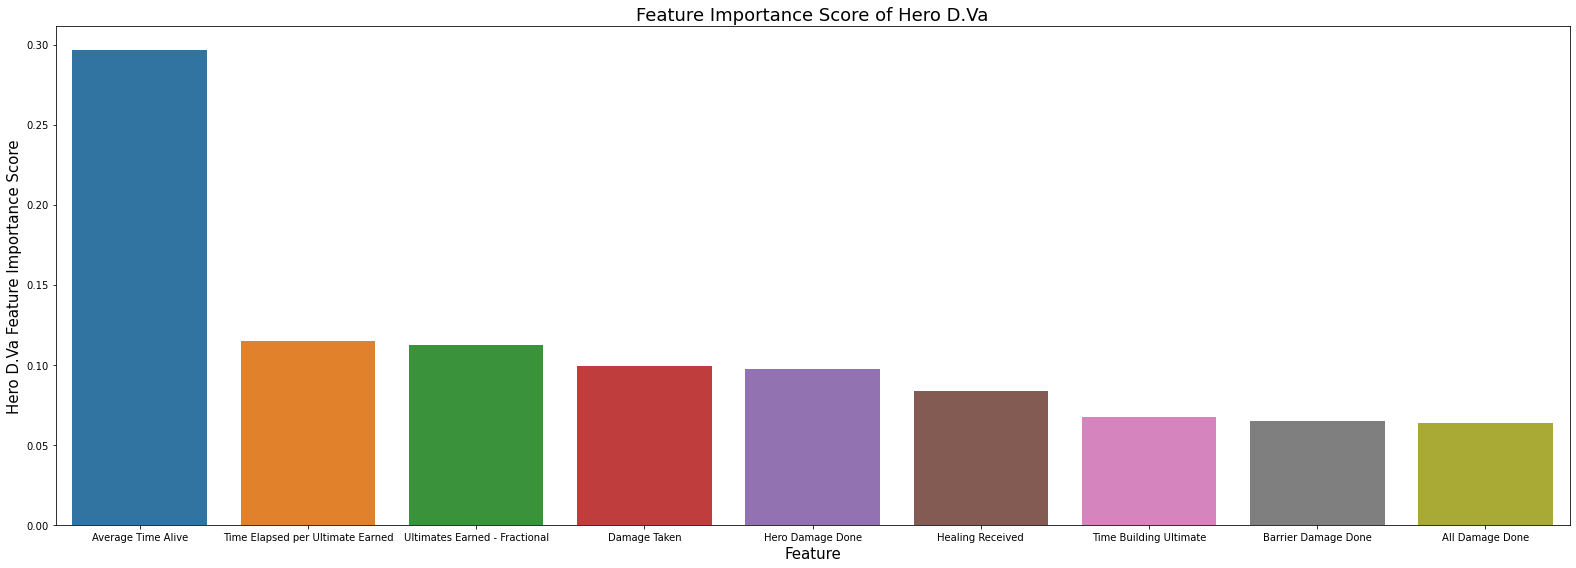

In [20]:
# plot of the Importance Score
plt.figure(figsize=(22,8))
# make barplot and sort bars
sns.barplot(x='Feature',
            y="Hero D.Va Feature Importance Score", 
            data=DVa_feature, 
            order=DVa_feature.sort_values('Hero D.Va Feature Importance Score',ascending = False).Feature)
# set labels
plt.xlabel("Feature", size=15)
plt.ylabel("Hero D.Va Feature Importance Score", size=15)
plt.title("Feature Importance Score of Hero D.Va", size=18)
plt.tight_layout()

From the above plot we can find that the top 3 important features for Hero D.Va are: 'Average Time Alive', 'Time Elapsed per Ultimate Earned', and 'Ultimates Earned - Fractional'.

### 4.3.2 Hero Ana Feature Analysis

In [21]:
# Create dataframe Ana_stat_unit_df of stat_name per unit for hero Ana
stat_list = ['All Damage Done','Average Time Alive','Barrier Damage Done','Damage Taken','Healing Received','Hero Damage Done','Time Building Ultimate','Time Elapsed per Ultimate Earned','Ultimates Earned - Fractional']
Ana_stat_unit_df = pd.DataFrame()

for stat in stat_list:
    result_Ana = regression('Ana',stat)
    stat_numeric_Ana = []
    for i in range(len(result_Ana[0])):
        stat_numeric_Ana.append(result_Ana[0][i][0])
    Ana_stat_unit_df[stat] = stat_numeric_Ana

# Add winning_rate column    
result_Ana = regression('Ana','All Damage Done')
# convert array to float
win_rate_Ana = []
for i in range(len(result_Ana[1])):
    win_rate_Ana.append(result_Ana[1][i][0])
Ana_stat_unit_df['winning_team_win_rate'] = win_rate_Ana
# The complete dataframe
Ana_stat_unit_df

,All Damage Done,Average Time Alive,Barrier Damage Done,Damage Taken,Healing Received,Hero Damage Done,Time Building Ultimate,Time Elapsed per Ultimate Earned,Ultimates Earned - Fractional,winning_team_win_rate
0,6.614111,0.187236,2.753471,4.766369,3.500405,3.365227,0.839564,0.237119,0.007471,0.750000
1,13.741728,0.444530,6.491325,4.191867,1.169835,6.797099,0.930605,0.813085,0.008647,0.666667
2,10.786385,0.473592,2.529016,4.444858,3.391101,8.231025,0.934113,0.636451,0.007733,1.000000
3,9.913597,1.000821,4.080559,4.119532,4.119531,5.833039,0.717433,0.297640,0.009675,1.000000
4,9.821406,0.304471,2.428824,5.275210,2.979032,7.392583,0.646216,0.160470,0.008409,0.750000
...,...,...,...,...,...,...,...,...,...,...
546,4.866589,0.240888,0.545255,4.370413,3.432099,4.321334,0.799482,0.170881,0.010975,1.000000
547,3.020140,0.100477,0.452147,3.653993,1.462148,2.567993,0.846278,0.149278,0.007766,0.666667
548,4.331202,0.322718,2.914771,4.144298,3.366268,4.080794,0.818969,0.138810,0.011204,1.000000
549,5.074231,0.113284,1.254995,2.748186,0.911173,3.819236,0.774239,0.150884,0.006733,0.600000


In [22]:
# check the range of the each stat_name 
Ana_stat_unit_df.iloc[:, :-1].describe().round(2)

,All Damage Done,Average Time Alive,Barrier Damage Done,Damage Taken,Healing Received,Hero Damage Done,Time Building Ultimate,Time Elapsed per Ultimate Earned,Ultimates Earned - Fractional
count,551.00,551.00,551.00,551.00,551.00,551.00,551.00,551.00,551.00
mean,8.11,0.29,2.92,4.06,2.48,5.21,0.78,0.24,0.01
std,2.38,0.23,1.71,1.48,1.20,1.65,0.09,0.25,0.00
min,1.88,0.07,0.20,0.65,0.40,1.08,0.44,0.05,0.00
25%,6.49,0.13,1.78,3.09,1.65,4.13,0.74,0.11,0.01
50%,8.06,0.21,2.65,4.00,2.38,5.16,0.78,0.16,0.01
75%,9.61,0.32,3.67,4.77,2.99,6.20,0.84,0.27,0.01
max,15.64,1.10,15.06,9.90,11.86,10.95,1.01,2.19,0.01


We can see that all the stat_names are in different range. In order to make sure that every stat_name gets equal importance, we will normalize the value. For example, predictor 'All Damage Done' is in range [1.88, 15.64] However, Average Time Alive is in [0.07, 1,10]

In [23]:
from sklearn.preprocessing import StandardScaler
# standardize the stat_name data
scaler_df = StandardScaler()

scaler_df.fit(Ana_stat_unit_df[['All Damage Done','Average Time Alive','Barrier Damage Done','Damage Taken','Healing Received','Hero Damage Done','Time Building Ultimate','Time Elapsed per Ultimate Earned','Ultimates Earned - Fractional']])

Ana_stat_unit_df[['All Damage Done','Average Time Alive','Barrier Damage Done','Damage Taken','Healing Received','Hero Damage Done','Time Building Ultimate','Time Elapsed per Ultimate Earned','Ultimates Earned - Fractional']] = scaler_df.transform(
                  Ana_stat_unit_df[['All Damage Done','Average Time Alive','Barrier Damage Done','Damage Taken','Healing Received','Hero Damage Done','Time Building Ultimate','Time Elapsed per Ultimate Earned','Ultimates Earned - Fractional']])
# check the finished data
Ana_stat_unit_df

,All Damage Done,Average Time Alive,Barrier Damage Done,Damage Taken,Healing Received,Hero Damage Done,Time Building Ultimate,Time Elapsed per Ultimate Earned,Ultimates Earned - Fractional,winning_team_win_rate
0,-0.630264,-0.439324,-0.097672,0.478663,0.849021,-1.121293,0.645921,-0.005145,-0.741646,0.750000
1,2.371924,0.674386,2.094504,0.089124,-1.089672,0.963814,1.707241,2.341820,-0.257863,0.666667
2,1.127118,0.800186,-0.229310,0.260664,0.758096,1.835026,1.748143,1.622064,-0.633775,1.000000
3,0.759496,3.082322,0.680638,0.040078,1.364043,0.378078,-0.777834,0.241469,0.164787,1.000000
4,0.720664,0.068134,-0.288071,0.823681,0.415315,1.325612,-1.608064,-0.317477,-0.355753,0.750000
...,...,...,...,...,...,...,...,...,...,...
546,-1.366329,-0.207086,-1.392746,0.210186,0.792201,-0.540389,0.178656,-0.275051,0.699449,1.000000
547,-2.144063,-0.814863,-1.447352,-0.275579,-0.846511,-1.605669,0.724196,-0.363083,-0.620098,0.666667
548,-1.591837,0.147117,-0.003073,0.056870,0.737438,-0.686535,0.405840,-0.405736,0.793749,1.000000
549,-1.278869,-0.759427,-0.976498,-0.889759,-1.304841,-0.845450,-0.115610,-0.356536,-1.044943,0.600000


In [24]:
# Fitting Random Forest Regression to the dataset
# import the regressor
from sklearn.ensemble import RandomForestRegressor
 
 # create regressor object
regressor_Ana = RandomForestRegressor(n_estimators = 100, random_state = 0)
 
# fit the regressor with x and y data
regressor_Ana.fit(Ana_stat_unit_df.iloc[:, :-1], Ana_stat_unit_df.iloc[:, -1]) 

# show the feature importance scores
Ana_feature = np.empty(shape=(9,2),dtype='object')

for i in range(9):
  Ana_feature[i,0] = Ana_stat_unit_df.iloc[:, :-1].columns[i]
  Ana_feature[i,1] = regressor_Ana.feature_importances_[i]

Ana_feature = pd.DataFrame(Ana_feature)
Ana_feature.columns = ['Feature','Hero Ana Feature Importance Score']
Ana_feature.sort_values('Hero Ana Feature Importance Score',ascending = False)

,Feature,Hero Ana Feature Importance Score
7,Time Elapsed per Ultimate Earned,0.237734
8,Ultimates Earned - Fractional,0.160652
1,Average Time Alive,0.12381
5,Hero Damage Done,0.089811
6,Time Building Ultimate,0.085113
2,Barrier Damage Done,0.081356
4,Healing Received,0.077704
0,All Damage Done,0.072311
3,Damage Taken,0.071509


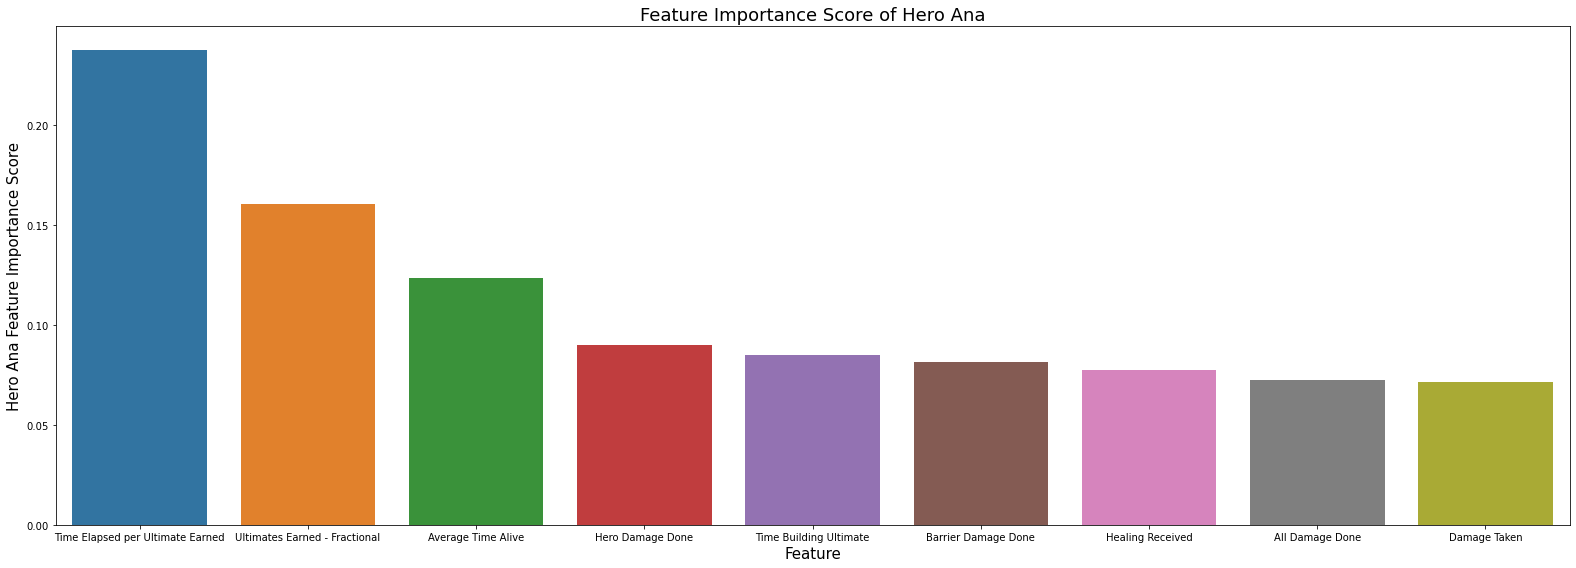

In [25]:
# plot of the Importance Score
plt.figure(figsize=(22,8))
# make barplot and sort bars
sns.barplot(x='Feature',
            y="Hero Ana Feature Importance Score", 
            data=Ana_feature, 
            order=Ana_feature.sort_values('Hero Ana Feature Importance Score',ascending = False).Feature)
# set labels
plt.xlabel("Feature", size=15)
plt.ylabel("Hero Ana Feature Importance Score", size=15)
plt.title("Feature Importance Score of Hero Ana", size=18)
plt.tight_layout()

From the above plot we can find that the top 3 important features for Hero Ana are: 'Time Elapsed per Ultimate Earned', 'Ultimates Earned - Fractional', and'Average Time Alive'.

### 4.3.3 Hero Soldier: 76 Feature Analysis

In [26]:
# Create dataframe Soldier_76_stat_unit_df of stat_name per unit for hero Soldier_76
stat_list = ['All Damage Done','Average Time Alive','Barrier Damage Done','Damage Taken','Healing Received','Hero Damage Done','Time Building Ultimate','Time Elapsed per Ultimate Earned','Ultimates Earned - Fractional']
Soldier_76_stat_unit_df = pd.DataFrame()

for stat in stat_list:
    result_Soldier_76 = regression('Soldier: 76',stat)
    stat_numeric_Soldier_76 = []
    for i in range(len(result_Soldier_76[0])):
        stat_numeric_Soldier_76.append(result_Soldier_76[0][i][0])
    Soldier_76_stat_unit_df[stat] = stat_numeric_Soldier_76

# Add winning_rate column    
result_Soldier_76 = regression('Soldier: 76','All Damage Done')
# convert array to float
win_rate_Soldier_76 = []
for i in range(len(result_Soldier_76[1])):
    win_rate_Soldier_76.append(result_Soldier_76[1][i][0])
Soldier_76_stat_unit_df['winning_team_win_rate'] = win_rate_Soldier_76
# The complete dataframe
Soldier_76_stat_unit_df

,All Damage Done,Average Time Alive,Barrier Damage Done,Damage Taken,Healing Received,Hero Damage Done,Time Building Ultimate,Time Elapsed per Ultimate Earned,Ultimates Earned - Fractional,winning_team_win_rate
0,27.614750,1.332731,10.005376,10.045909,7.341749,17.595853,0.990438,1.200223,0.011158,0.750000
1,23.869538,0.371790,7.833029,6.710576,4.456380,16.009255,0.841841,0.428711,0.005870,1.000000
2,39.729214,0.997078,16.173477,4.391899,4.391901,23.555737,0.997078,1.356316,0.012385,0.600000
3,23.869538,0.371790,7.833029,6.710576,4.456380,16.009255,0.841841,0.428711,0.000065,0.666667
4,23.869538,0.371790,7.833029,6.710576,4.456380,16.009255,0.841841,0.428711,0.005870,0.600000
...,...,...,...,...,...,...,...,...,...,...
65,23.869538,0.371790,7.833029,6.710576,4.456380,16.009255,0.841841,0.428711,0.000082,1.000000
66,20.971389,0.559452,4.540582,5.519000,4.622674,16.425130,0.875612,0.601916,0.008257,0.666667
67,23.869538,0.371790,7.833029,6.710576,4.456380,16.009255,0.841841,0.428711,0.000016,0.571429
68,16.004770,0.300795,6.944909,5.508473,3.503446,9.059860,1.002672,0.727158,0.006912,0.571429


In [27]:
# check the range of the each stat_name 
Soldier_76_stat_unit_df.iloc[:, :-1].describe().round(2)

,All Damage Done,Average Time Alive,Barrier Damage Done,Damage Taken,Healing Received,Hero Damage Done,Time Building Ultimate,Time Elapsed per Ultimate Earned,Ultimates Earned - Fractional
count,70.00,70.00,70.00,70.00,70.00,70.00,70.00,70.00,70.00
mean,24.18,0.56,8.71,6.86,4.58,15.79,0.88,0.77,0.01
std,5.55,0.42,5.46,3.64,2.64,4.08,0.09,0.72,0.00
min,10.73,0.11,1.25,2.54,0.39,5.42,0.60,0.11,0.00
25%,21.08,0.31,5.82,5.47,3.45,14.07,0.84,0.37,0.00
50%,23.87,0.37,7.83,6.71,4.46,16.01,0.86,0.43,0.01
75%,26.33,0.89,9.12,7.28,4.94,16.82,0.95,0.89,0.01
max,39.83,1.99,38.99,33.06,21.97,29.97,1.01,3.17,0.01


We can see that all the stat_names are in different range. In order to make sure that every stat_name gets equal importance, we will normalize the value. For example, predictor 'All Damage Done' is in range [10.73, 39.83] However, Average Time Alive is in [0.11, 1.99]

In [28]:
from sklearn.preprocessing import StandardScaler
# standardize the stat_name data
scaler_df = StandardScaler()

scaler_df.fit(Soldier_76_stat_unit_df[['All Damage Done','Average Time Alive','Barrier Damage Done','Damage Taken','Healing Received','Hero Damage Done','Time Building Ultimate','Time Elapsed per Ultimate Earned','Ultimates Earned - Fractional']])

Soldier_76_stat_unit_df[['All Damage Done','Average Time Alive','Barrier Damage Done','Damage Taken','Healing Received','Hero Damage Done','Time Building Ultimate','Time Elapsed per Ultimate Earned','Ultimates Earned - Fractional']] = scaler_df.transform(
                  Soldier_76_stat_unit_df[['All Damage Done','Average Time Alive','Barrier Damage Done','Damage Taken','Healing Received','Hero Damage Done','Time Building Ultimate','Time Elapsed per Ultimate Earned','Ultimates Earned - Fractional']])
# check the finished data
Soldier_76_stat_unit_df

,All Damage Done,Average Time Alive,Barrier Damage Done,Damage Taken,Healing Received,Hero Damage Done,Time Building Ultimate,Time Elapsed per Ultimate Earned,Ultimates Earned - Fractional,winning_team_win_rate
0,0.622306,1.843178,0.239533,0.882519,1.053079,0.445541,1.197684,0.602233,1.304456,0.750000
1,-0.057134,-0.460111,-0.161277,-0.040865,-0.047380,0.053702,-0.431708,-0.478996,-0.042672,1.000000
2,2.820062,1.038648,1.377582,-0.682789,-0.071972,1.917445,1.270497,0.820989,1.617230,0.600000
3,-0.057134,-0.460111,-0.161277,-0.040865,-0.047380,0.053702,-0.431708,-0.478996,-1.521614,0.666667
4,-0.057134,-0.460111,-0.161277,-0.040865,-0.047380,0.053702,-0.431708,-0.478996,-0.042672,0.600000
...,...,...,...,...,...,...,...,...,...,...
65,-0.057134,-0.460111,-0.161277,-0.040865,-0.047380,0.053702,-0.431708,-0.478996,-1.517454,1.000000
66,-0.582904,-0.010303,-0.768752,-0.370752,0.016043,0.156410,-0.061407,-0.236259,0.565344,0.666667
67,-0.057134,-0.460111,-0.161277,-0.040865,-0.047380,0.053702,-0.431708,-0.478996,-1.534095,0.571429
68,-1.483928,-0.630279,-0.325141,-0.373667,-0.410823,-1.662580,1.331833,-0.060740,0.222727,0.571429


In [29]:
# Fitting Random Forest Regression to the dataset
# import the regressor
from sklearn.ensemble import RandomForestRegressor
 
 # create regressor object
regressor_Soldier_76 = RandomForestRegressor(n_estimators = 100, random_state = 0)
 
# fit the regressor with x and y data
regressor_Soldier_76.fit(Soldier_76_stat_unit_df.iloc[:, :-1], Soldier_76_stat_unit_df.iloc[:, -1]) 

# show the feature importance scores
Soldier_76_feature = np.empty(shape=(9,2),dtype='object')

for i in range(9):
  Soldier_76_feature[i,0] = Soldier_76_stat_unit_df.iloc[:, :-1].columns[i]
  Soldier_76_feature[i,1] = regressor_Soldier_76.feature_importances_[i]

Soldier_76_feature = pd.DataFrame(Soldier_76_feature)
Soldier_76_feature.columns = ['Feature','Hero Soldier_76 Feature Importance Score']
Soldier_76_feature.sort_values('Hero Soldier_76 Feature Importance Score',ascending = False)

,Feature,Hero Soldier_76 Feature Importance Score
0,All Damage Done,0.198988
8,Ultimates Earned - Fractional,0.18272
5,Hero Damage Done,0.144968
2,Barrier Damage Done,0.109189
4,Healing Received,0.106095
1,Average Time Alive,0.104654
3,Damage Taken,0.055556
6,Time Building Ultimate,0.052868
7,Time Elapsed per Ultimate Earned,0.044963


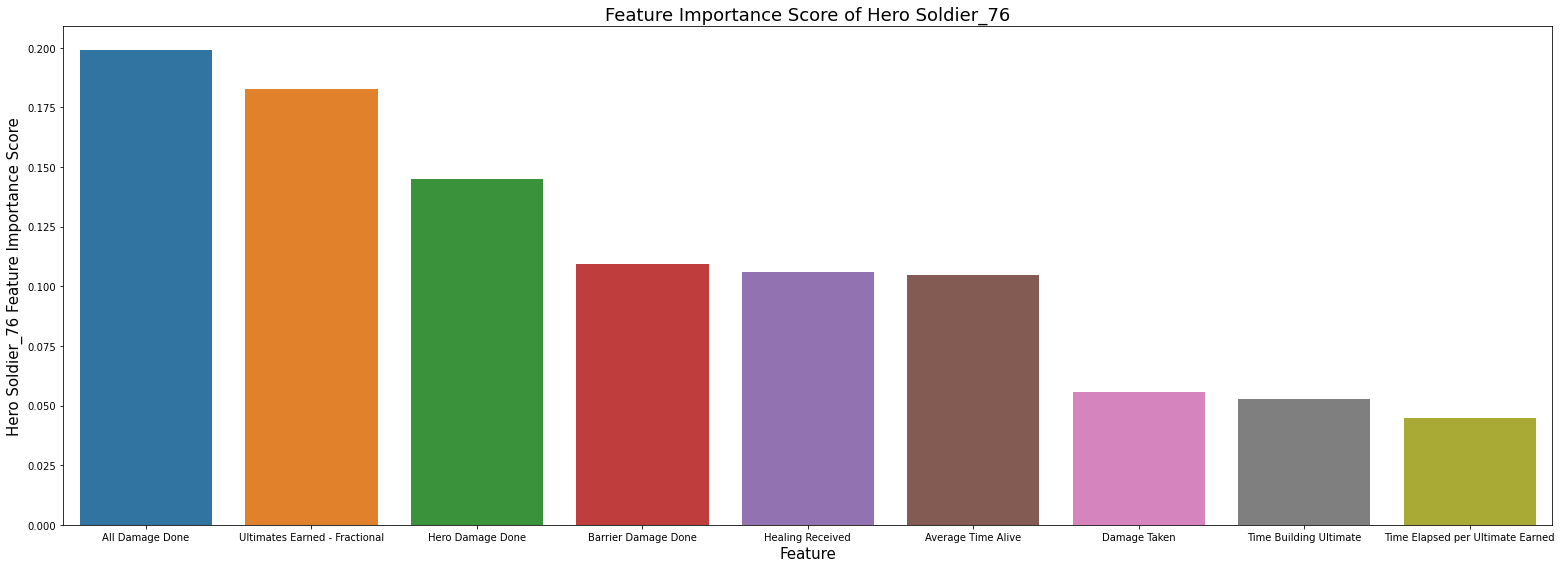

In [30]:
# plot of the Importance Score
plt.figure(figsize=(22,8))
# make barplot and sort bars
sns.barplot(x='Feature',
            y="Hero Soldier_76 Feature Importance Score", 
            data=Soldier_76_feature, 
            order=Soldier_76_feature.sort_values('Hero Soldier_76 Feature Importance Score',ascending = False).Feature)
# set labels
plt.xlabel("Feature", size=15)
plt.ylabel("Hero Soldier_76 Feature Importance Score", size=15)
plt.title("Feature Importance Score of Hero Soldier_76", size=18)
plt.tight_layout()

From the above plot we can find that the top 3 important features for Hero Ana are: 'All Damage Done', 'Ultimates Earned - Fractional', and 'Hero Damage Done'.

The top 3 important features for Hero D.Va are: 'Average Time Alive', 'Time Elapsed per Ultimate Earned', and 'Ultimates Earned - Fractional'. The top 3 important features for Hero Ana are: 'Time Elapsed per Ultimate Earned', 'Ultimates Earned - Fractional', and'Average Time Alive'.The top 3 important features for Hero Ana are: 'All Damage Done', 'Ultimates Earned - Fractional', and 'Hero Damage Done'. We can see that stat_name 'Ultimates Earned - Fractional' appeared in all the three heroes top important feature. 

### 4.4 Section Conclusion

After the analysis, it is clear that our model comprises reasonable results based on our fluid and crystalized intelligence. For instance, playing D.Va as a tank, you have to be at the forefront of the team. Your damage taken is the key to protect other units ion your team. Though mobility is stellar for this hero, you should have just stick with team collaborative actions. It is also backed up by the gameplay videos from the league.

And when it comes to Soldier 76, though it has weak DPS rate, you should still keep clicking on your left trigger. It is important for 2 reasons. As we can see that the ultimate earned is extremely important as it offers aim assistance. Though your right click secondary skill could do more damage in one click, however, it cannot offset the importance of ultimate skills. This is a common misconception for many players. Therefore, next time you wanna play the game with higher likelihood to win, you should follow what the model has suggested.